In [1]:
#if the library are not install through command line, you can also go to the kernel > conda package and install
# * pandas
# * matplotlib
# * basemap
#conda install pandas
import numpy as np
import pandas as pd
import datetime
from itertools import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
from matplotlib import mlab
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
%matplotlib inline

path_station_boards = 'data/station-boards-dump-4-months.tsv'
path_stops = 'data/stops.txt'


In [2]:
print(datetime.datetime.now())
parser = lambda date: pd.datetime.strptime(date, '%a %b %d %Y %H:%M:%S GMT%z (%Z)')


2017-02-23 06:01:23.151474


In [3]:
parser('Sun Mar 27 2016 03:06:55 GMT+0200 (CEST)')

datetime.datetime(2016, 3, 27, 3, 6, 55, tzinfo=datetime.timezone(datetime.timedelta(0, 7200), 'CEST'))

In [4]:
#we restict the analysis to the first 2 millions lines. Head to a more parallel mode (spark to dealing with the entire set)
print(datetime.datetime.now())
df_station_boards = pd.read_csv(path_station_boards,
                                sep='\t',
                                nrows=2000000,
                                parse_dates=[1,4],
                                date_parser=parser
                               ).fillna(0)

2017-02-23 06:01:24.472059


In [7]:
print(datetime.datetime.now())
df_station_boards['delta_mesure'] = df_station_boards.apply(lambda row:(row.timestamp-row.stop_departure).seconds if (row.stop_departure<row.timestamp) else -(row.stop_departure-row.timestamp).seconds, axis=1)/60
df_station_boards['stop_departure_hour'] = df_station_boards.stop_departure.apply(lambda t:t.hour)
df_station_boards['is_delayed'] = df_station_boards.stop_delay.apply(lambda d:d>0)


2017-02-23 06:15:35.462729


In [8]:
print(datetime.datetime.now())
df_stops = pd.read_csv(path_stops, sep=',')
df_stops['stop_id']=df_stops['stop_id'].replace(':.*', '', regex=True).astype(int)
df_stops= df_stops.drop_duplicates(subset='stop_id', keep='last')
df_stops = df_stops.set_index('stop_id')


df_station_boards['stop_lat']=list(df_stops.loc[df_station_boards['stop_station_id']]['stop_lat'])
df_station_boards['stop_lon']=list(df_stops.loc[df_station_boards['stop_station_id']]['stop_lon'])


2017-02-23 06:22:02.234866


In [9]:
print(datetime.datetime.now())
df_station_boards_last = df_station_boards.drop_duplicates(subset='id', keep='last')
df_station_boards_last.head()

2017-02-23 06:22:10.043870


,id,timestamp,stop_station_id,stop_station_name,stop_departure,name,category,operator,to,stop_delay,stop_prognosis_capacity1st,stop_prognosis_capacity2nd,delta_mesure,stop_departure_hour,is_delayed,stop_lat,stop_lon
0,8530011/R 328/Les Ponts-de-Martel/Fri Jan 08 2...,2016-01-08 17:20:04+01:00,8530011,Les Coeudres-Est,2016-01-08 17:20:00+01:00,R 328,R,TRN-cmn,Les Ponts-de-Martel,0.0,-1,-1,0.066667,17,False,47.028766,6.789469
1,8530012/R 328/Les Ponts-de-Martel/Fri Jan 08 2...,2016-01-08 17:20:06+01:00,8530012,Petit-Martel-Est,2016-01-08 17:22:00+01:00,R 328,R,TRN-cmn,Les Ponts-de-Martel,0.0,-1,-1,-1.900000,17,False,47.013675,6.765242
2,8530064/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:26+01:00,8530064,Bex Pont-Neuf,2016-01-08 17:09:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-3.566667,17,False,46.250520,7.020836
3,8530066/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:27+01:00,8530066,Grand-Moulin,2016-01-08 17:10:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-4.550000,17,False,46.252616,7.023231
4,8530067/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:27+01:00,8530067,Les Salines,2016-01-08 17:11:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-5.550000,17,False,46.254836,7.027649


In [10]:
print(datetime.datetime.now())
#rate of delayed
df_station_boards_delayed=df_station_boards_last[df_station_boards_last['stop_delay']>0]
tot_station_boards = len(df_station_boards_last)
tot_station_boards_delayed = len(df_station_boards_delayed)
tot_station_boards_delayed/tot_station_boards*100

2017-02-23 06:25:09.267164


4.067681168032693

2017-02-23 06:25:10.193333


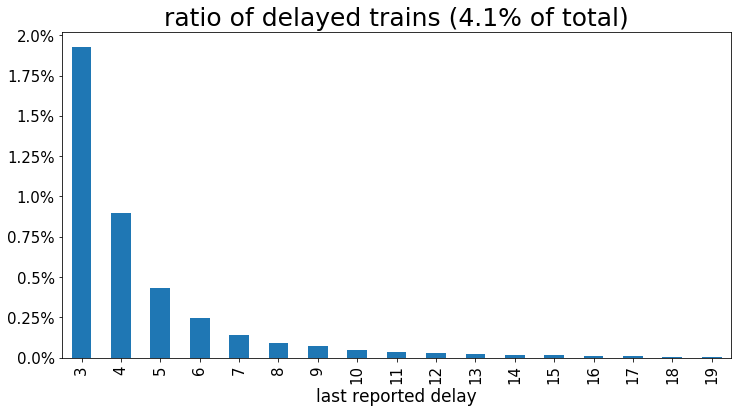

In [11]:
print(datetime.datetime.now())
def to_percent(y, position):
    s = str(100 * y)
    return s + '%'
    
formatter_percent = FuncFormatter(to_percent)

plot_delay_dist = (df_station_boards_delayed.groupby('stop_delay').size()/tot_station_boards)[range(3,20)].plot(kind='bar', figsize=(12,6))
plot_delay_dist.set_xlabel("last reported delay", fontsize=17)
plot_delay_dist.set_title('ratio of delayed trains (%2.1f%% of total)' %(tot_station_boards_delayed/tot_station_boards*100), fontsize=25)
plot_delay_dist.tick_params(axis='both', which='major', labelsize=15)
plot_delay_dist.yaxis.set_major_formatter(formatter_percent)


2017-02-23 06:25:12.751490


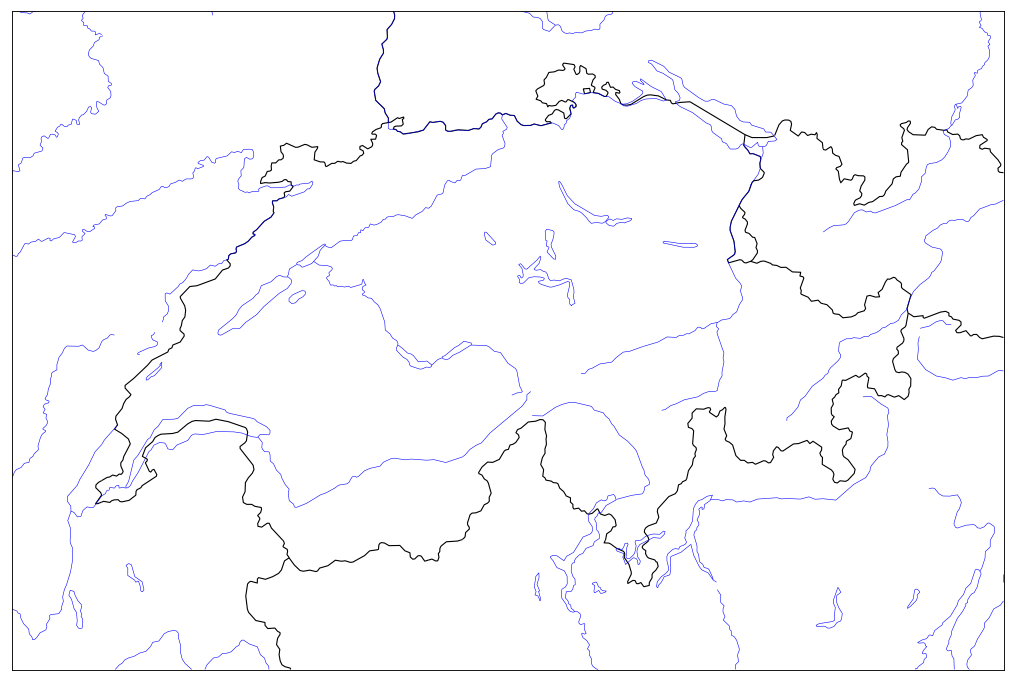

In [12]:
print(datetime.datetime.now())
def setup_map():
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    lat_min=45.5
    lat_max=48
    lon_min=5.5
    lon_max=11
    m = Basemap(projection='merc',llcrnrlat=lat_min,urcrnrlat=lat_max,\
            llcrnrlon=lon_min,urcrnrlon=lon_max,lat_ts=10, resolution ='h')

    plt.clf()
    m.drawcountries(linewidth=1.0)
    m.drawrivers(color='blue')
    m.drawcoastlines(color='blue',linewidth=0.5)
    return m

m=setup_map()
plt.show()

2017-02-23 06:25:33.382826


/users/alex/local/anaconda3/envs/cff/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3459: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/users/alex/local/anaconda3/envs/cff/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3472: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


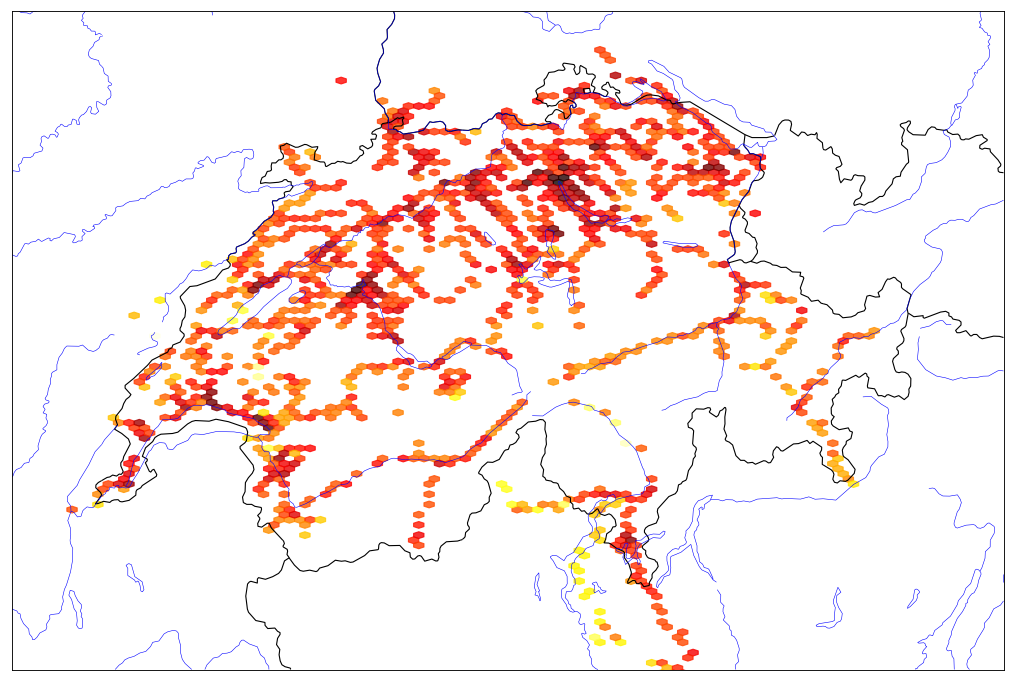

In [13]:
print(datetime.datetime.now())

m=setup_map()
x = list(df_station_boards_last.stop_lon.dropna())
y = list(df_station_boards_last.stop_lat.dropna())
x,y=m(x,y)
hb = m.hexbin(np.array(x),np.array(y),gridsize=130, mincnt=10, cmap='hot_r', alpha=0.8, bins='log')

plt.show()


In [30]:
n_bins = 10
x = np.random.randn(1000, 3)
x


array([[ 0.6313413 , -0.40226749,  1.85339255],
       [-1.28987555, -0.45702717, -0.24878996],
       [ 0.76129858,  1.28995244,  0.20332987],
       ..., 
       [-1.64874829,  1.37590213, -1.27134482],
       [-0.293518  ,  0.19873439, -0.03646636],
       [ 0.57250552, -0.07624635, -1.63365062]])

2017-02-23 06:25:58.254973


/users/alex/local/anaconda3/envs/cff/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3459: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/users/alex/local/anaconda3/envs/cff/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3472: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


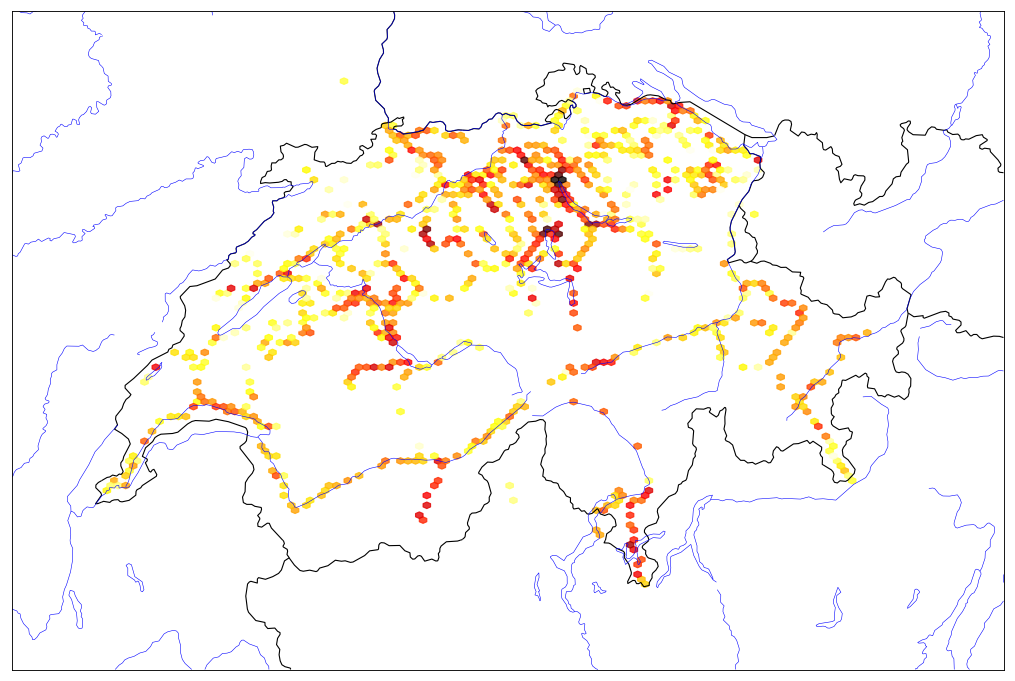

In [14]:
print(datetime.datetime.now())
m=setup_map()
x = list(df_station_boards_delayed.stop_lon.dropna())
y = list(df_station_boards_delayed.stop_lat.dropna())
x,y=m(x,y)
hb = m.hexbin(np.array(x),np.array(y),gridsize=130, mincnt=10, cmap='hot_r', alpha=0.8, bins='log')

plt.show()

2017-02-23 06:26:19.071819


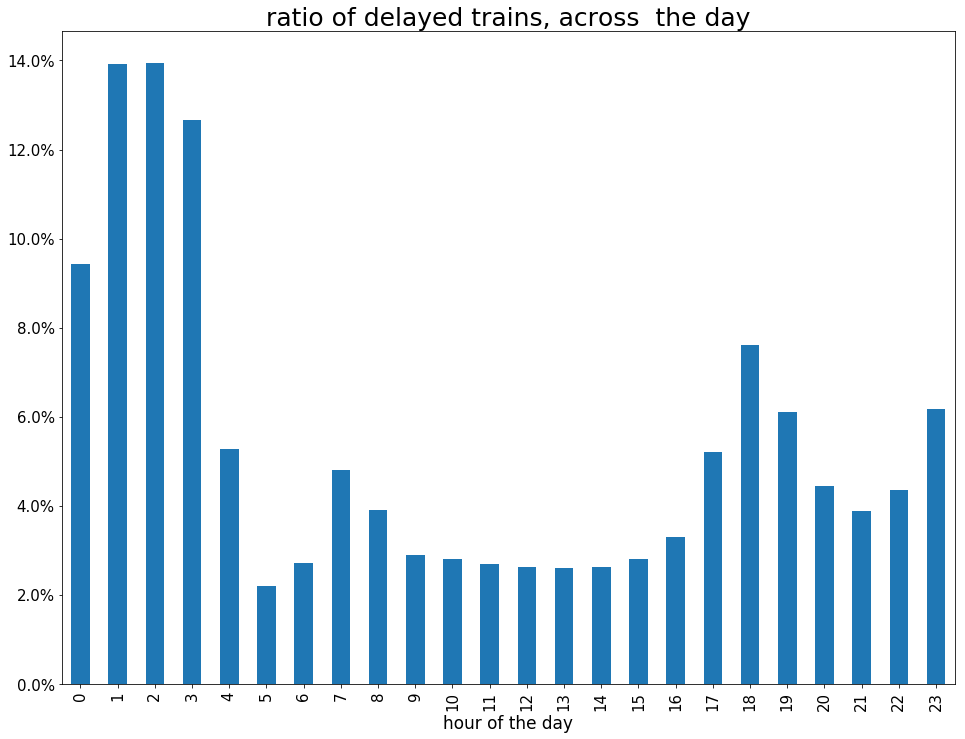

In [15]:
print(datetime.datetime.now())
tot_per_hour = df_station_boards_last.groupby('stop_departure_hour').size()
delayed_per_hour = df_station_boards_delayed.groupby('stop_departure_hour').size()

plot_delay_dist = (delayed_per_hour/tot_per_hour).plot(kind='bar', figsize=(16,12))
plot_delay_dist.set_xlabel("hour of the day", fontsize=17)
plot_delay_dist.set_title('ratio of delayed trains, across  the day', fontsize=25)
plot_delay_dist.tick_params(axis='both', which='major', labelsize=15)
plot_delay_dist.yaxis.set_major_formatter(formatter_percent)



2017-02-23 06:26:30.419513


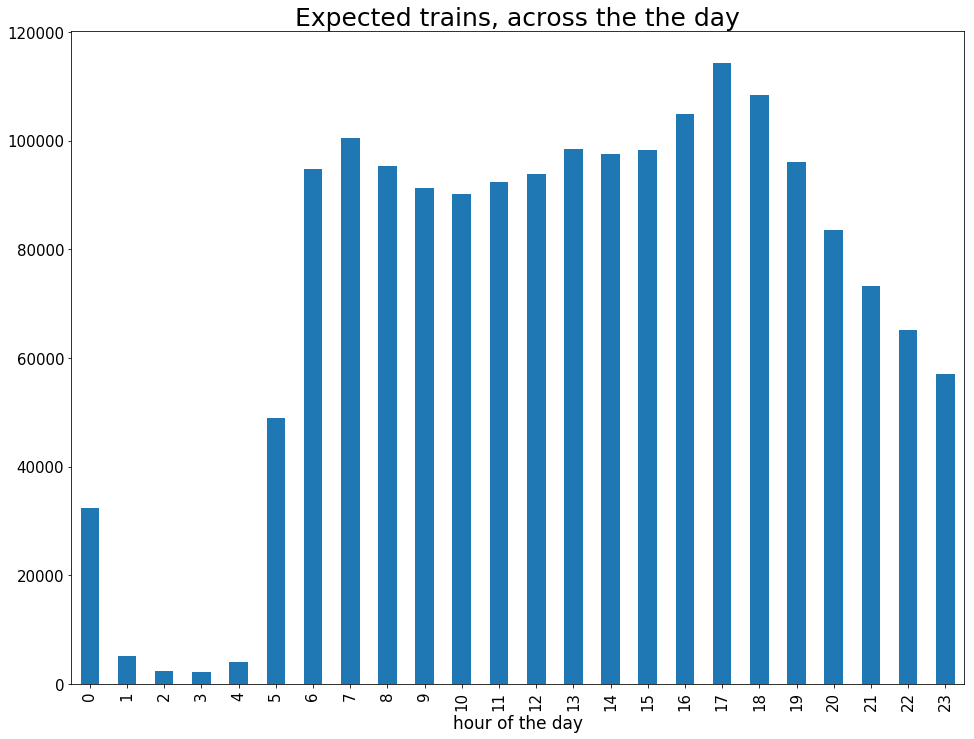

In [16]:
print(datetime.datetime.now())
plot_delay_dist = (tot_per_hour).plot(kind='bar', figsize=(16,12))
plot_delay_dist.set_xlabel("hour of the day", fontsize=17)
plot_delay_dist.set_title('Expected trains, across the the day', fontsize=25)
plot_delay_dist.tick_params(axis='both', which='major', labelsize=15)


2017-02-23 06:26:31.881552


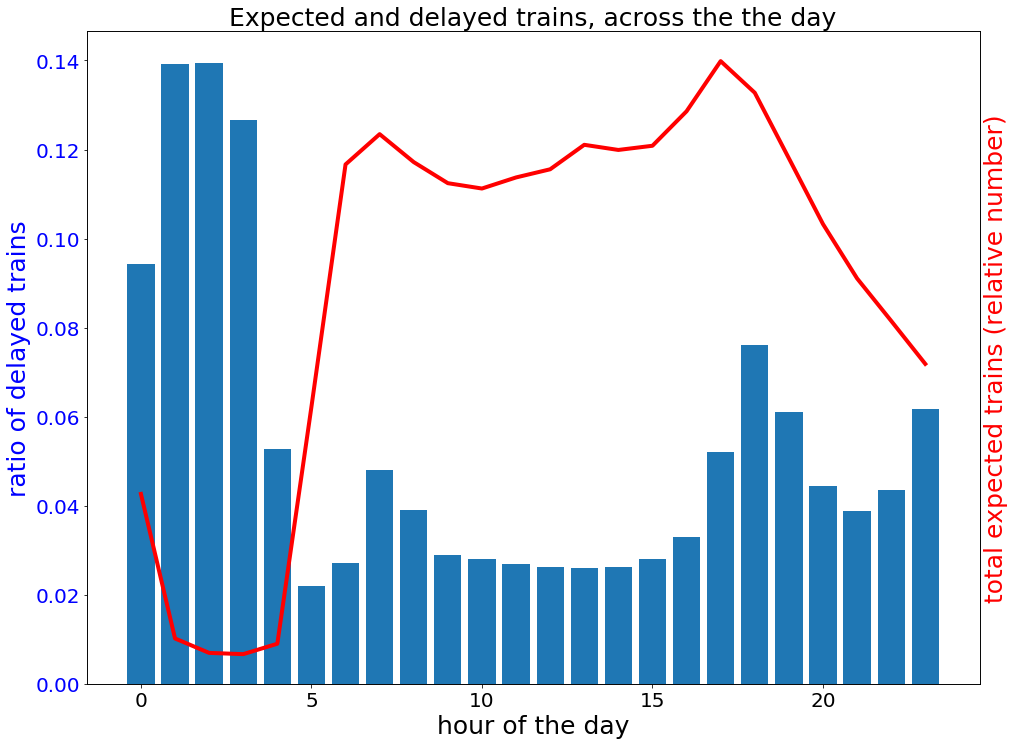

In [17]:
print(datetime.datetime.now())
fig, ax1 = plt.subplots(figsize=(16,12))
t = np.arange(0, 24, 1)
ax1.bar(t, delayed_per_hour/tot_per_hour)
ax1.set_xlabel('hour of the day', fontsize=25)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('ratio of delayed trains', color='b', fontsize=25)
for tl in ax1.get_yticklabels():
    tl.set_color('b')

plt.tick_params(axis='both', which='major', labelsize=20)

ax2 = ax1.twinx()
ax2.plot(t, tot_per_hour, 'r', linewidth=4)
ax2.set_ylabel('total expected trains (relative number)', color='r', fontsize=25)
ax2.get_yaxis().set_ticks([])

ax1.set_title('Expected and delayed trains, across the the day', fontsize=25)

plt.show()

In [18]:
print(datetime.datetime.now())
df_city = df_station_boards_last[df_station_boards_last.apply(lambda row:(row.stop_station_name == 'Lausanne') & ("Genève" in row.to) &(row.stop_departure.dayofweek<5), axis=1)]


2017-02-23 06:26:32.943152


In [19]:
def get_capacity(clazz, level):
    x  = df_city[df_city['stop_prognosis_capacity' +clazz] == level].groupby('stop_departure_hour').size()
    r = [0] * 24
    for i in x.keys():
        r[i] = x[i]
    return r



2017-02-23 06:55:53.577935


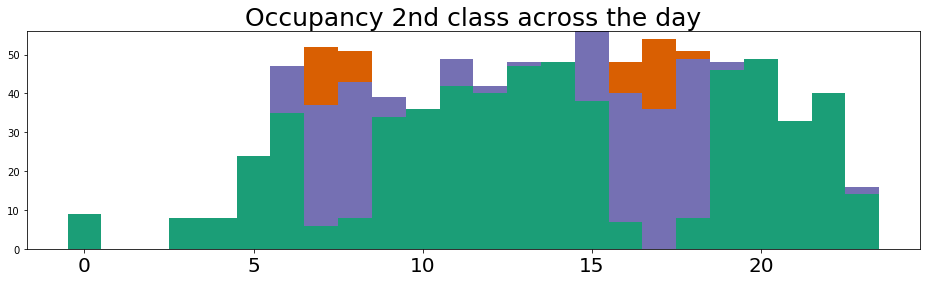

In [36]:
print(datetime.datetime.now())
capacity_2nd_1  = get_capacity('2nd',1)
capacity_2nd_2  = get_capacity('2nd',2)
capacity_2nd_3  = get_capacity('2nd',3)

plt.figure(figsize=(16,4))
hod = range(0,24)
plt.bar(hod, capacity_2nd_1, 1, color='#1b9e77')
plt.bar(hod, capacity_2nd_2, 1, color='#7570b3', bottom = capacity_2nd_1)
plt.bar(hod, capacity_2nd_3, 1, color='#d95f02', bottom = [capacity_2nd_1[i] + capacity_2nd_2[i] for i in hod])
plt.tick_params(axis='x', which='major', labelsize=20)
plt.title('Occupancy 2nd class across the day', fontsize=25)
plt.show()

2017-02-23 06:57:22.875045


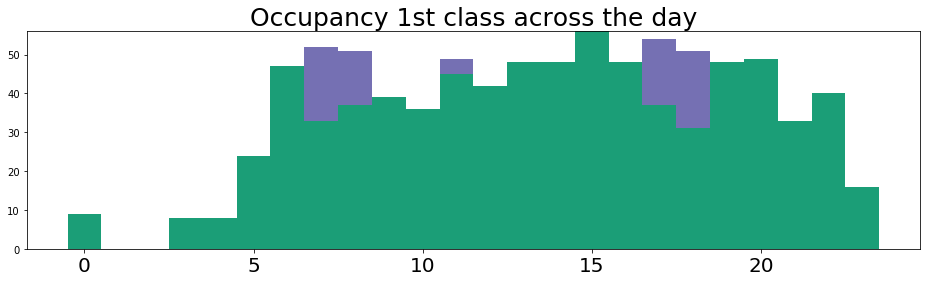

In [37]:
print(datetime.datetime.now())
capacity_1_1  = get_capacity('1st',1)
capacity_1_2  = get_capacity('1st',2)
capacity_1_3  = get_capacity('1st',3)

plt.figure(figsize=(16,4))
hod = range(0,24)
plt.bar(hod, capacity_1_1, 1, color='#1b9e77')
plt.bar(hod, capacity_1_2, 1, color='#7570b3', bottom = capacity_1_1)
plt.bar(hod, capacity_1_3, 1, color='#d95f02', bottom = [capacity_1_1[i] + capacity_1_2[i] for i in hod])
plt.tick_params(axis='x', which='major', labelsize=20)
plt.title('Occupancy 1st class across the day', fontsize=25)
plt.show()